# W2 - Accessibility (Distance Fields)

In this workshop we will learn the foundations to quantitatively approach spatial accessibility. We will learn about distance fields, construct a euclidean distance field, and construct a manifold distance field.

## 0. Initialization

### 0.1 Importing the packages

In [1]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np

#pv.set_jupyter_backend("ipyvtklink")

# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

### 0.2 import meshes

In [2]:
envelope_path = os.path.relpath('../data/meshes/compulsory_envelope.obj')
context_path = os.path.relpath('../data/meshes/immediate_context.obj')

# load the mesh from file
envelope_mesh = tm.load(envelope_path)
context_mesh = tm.load(context_path)

# Check if the mesh is watertight
print(envelope_mesh.is_watertight)
print(context_mesh.is_watertight)

True
False


In [3]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# adding the meshes
p.add_mesh(tri_to_pv(envelope_mesh), color='#abd8ff')
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
# p.show()

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x000001A43EB60910) at 0x000001A448795100>

### 0.3 Importing the Envelope Lattice

In [4]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/meshes/voxelized_envelope_highres.csv')
envelope_lattice = tg.lattice_from_csv(lattice_path)

In [5]:
# initiating the plotter
p = pv.Plotter()

# fast visualization of the lattice
envelope_lattice.fast_vis(p)

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
#p.show()

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x000001A43EB60B10) at 0x000001A43F90DF40>

### 0.4 Importing the Street Points

In [6]:
# import the streetnetwork as a point cloud
e_p= tg.cloud_from_csv("../data/meshes/east_point.csv")
n_p= tg.cloud_from_csv("../data/meshes/north_point.csv")
w_p= tg.cloud_from_csv("../data/meshes/west_point.csv")
s_p= tg.cloud_from_csv("../data/meshes/south_point.csv")

In [7]:
# initiating the plotter
p = pv.Plotter()

# fast visualization of the lattice
envelope_lattice.fast_vis(p)

# fast visualization of the point cloud
e_p.fast_notebook_vis(p)
n_p.fast_notebook_vis(p)
w_p.fast_notebook_vis(p)
s_p.fast_notebook_vis(p)
# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(785.7351488880344, 708.3187438880343, 742.5460610261134),
 (65.08283250000001, -12.333572500000002, 21.89374463807907),
 (0.0, 0.0, 1.0)]

### East

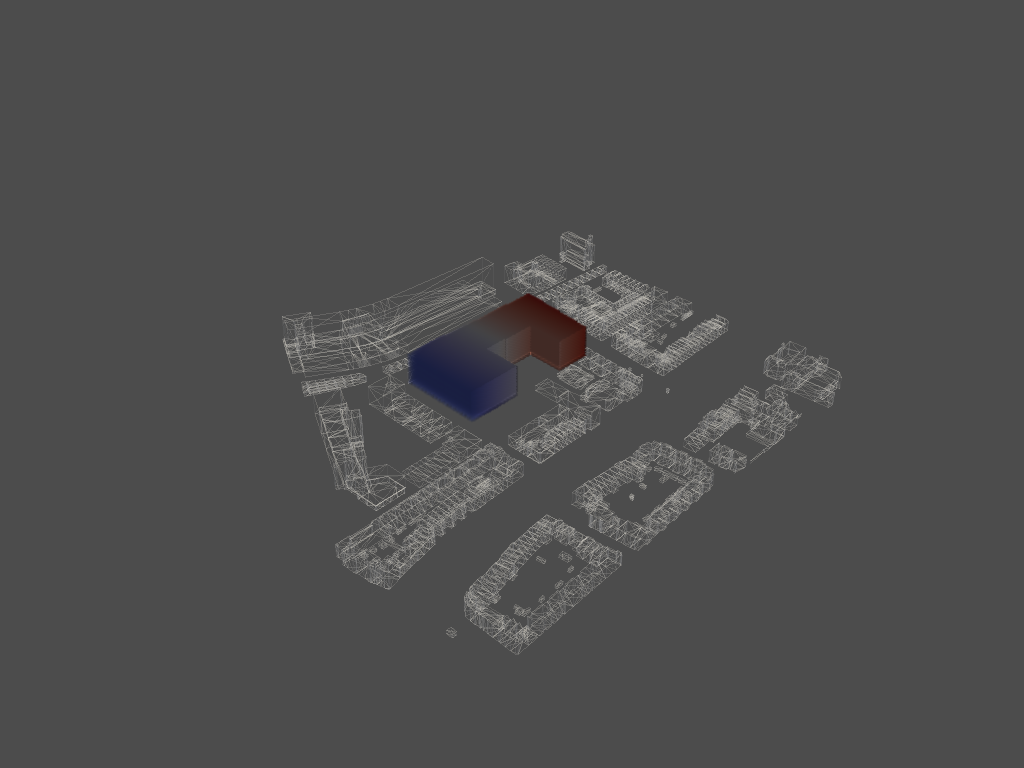

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [8]:
# extracting the centroid of all voxels
env_cens = envelope_lattice.centroids_threshold(-1)

# initializing the distance matrix
dist_m = []
# for each voxel ...
for voxel_cen in env_cens:
    # initializing the distance vector (per each voxel)
    dist_v = []
    # for each street point ...
    for street_point in e_p:
        # find the difference vector
        diff = voxel_cen - street_point
        # raise the components to the power of two
        diff_p2 = diff**2
        # sum the components
        diff_p2s = diff_p2.sum()
        # compute the square root 
        dist = diff_p2s**0.5
        # add the distance to the distance vector
        dist_v.append(dist)
    # add the distance vector to the distance matrix
    dist_m.append(dist_v)
# change the distance matrix type, from list to array
dist_m = np.array(dist_m)

# find the distance to the closest street point for each voxel
min_dist = dist_m.min(axis=1)
# convert the minimum distance list to a lattice
street_eu_distance_lattice = tg.to_lattice(min_dist.reshape(envelope_lattice.shape), envelope_lattice)
# zero the value of the exterior voxels
e_d = street_eu_distance_lattice * envelope_lattice
e_d=(e_d-e_d.min())/(e_d.max()-e_d.min())

# initiating the plotter
p = pv.Plotter()
l=e_d
# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Distance"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# # fast visualization of the point cloud
# street_pc.fast_notebook_vis(p)

# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6]) * 1.5
p.add_volume(grid, cmap="coolwarm", opacity=opacity, shade=True, show_scalar_bar=False)

# plotting
p.show()


In [9]:
e_csv_path = os.path.relpath('../data/fields/east_o.csv')
e_d.to_csv(e_csv_path)

### South

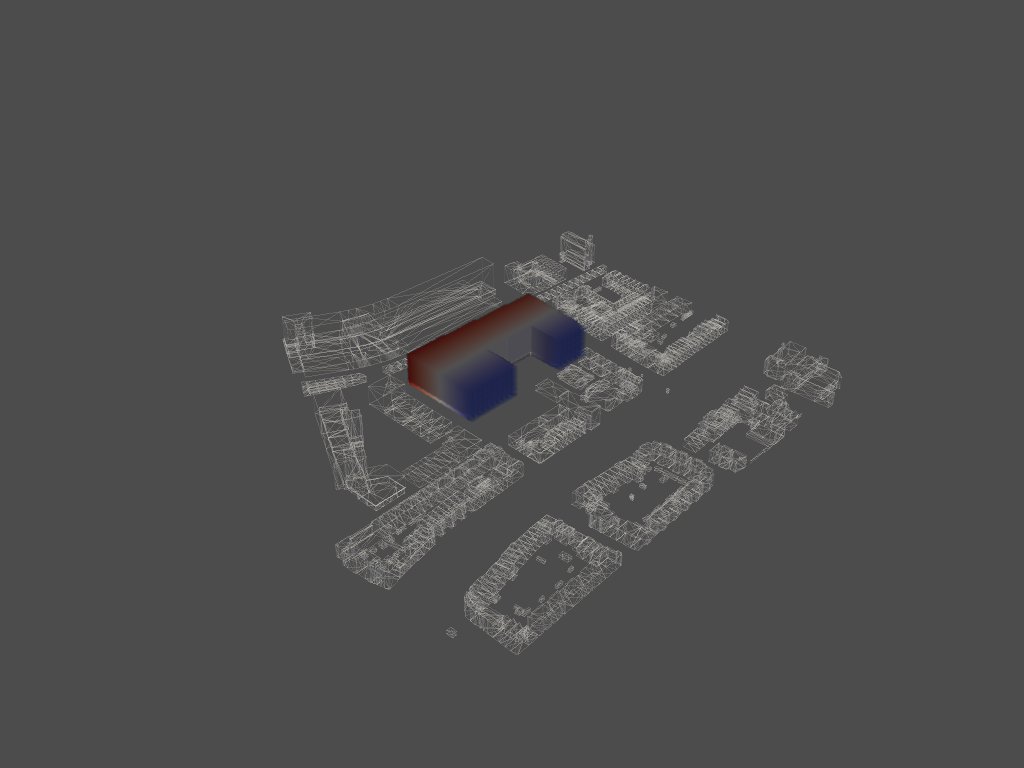

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [10]:
# extracting the centroid of all voxels
env_cens = envelope_lattice.centroids_threshold(-1)

# initializing the distance matrix
dist_m = []
# for each voxel ...
for voxel_cen in env_cens:
    # initializing the distance vector (per each voxel)
    dist_v = []
    # for each street point ...
    for street_point in n_p:
        # find the difference vector
        diff = voxel_cen - street_point
        # raise the components to the power of two
        diff_p2 = diff**2
        # sum the components
        diff_p2s = diff_p2.sum()
        # compute the square root 
        dist = diff_p2s**0.5
        # add the distance to the distance vector
        dist_v.append(dist)
    # add the distance vector to the distance matrix
    dist_m.append(dist_v)
# change the distance matrix type, from list to array
dist_m = np.array(dist_m)

# find the distance to the closest street point for each voxel
min_dist = dist_m.min(axis=1)
# convert the minimum distance list to a lattice
street_eu_distance_lattice = tg.to_lattice(min_dist.reshape(envelope_lattice.shape), envelope_lattice)
# zero the value of the exterior voxels
n_d = street_eu_distance_lattice * envelope_lattice
n_d=(n_d-n_d.min())/(n_d.max()-n_d.min())

# initiating the plotter
p = pv.Plotter()
l=n_d
# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Distance"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# # fast visualization of the point cloud
# street_pc.fast_notebook_vis(p)

# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6]) * 1.5
p.add_volume(grid, cmap="coolwarm", opacity=opacity, shade=True, show_scalar_bar=False)

# plotting
p.show()


In [11]:
n_csv_path = os.path.relpath('../data/fields/south_o.csv')
n_d.to_csv(n_csv_path)

### West

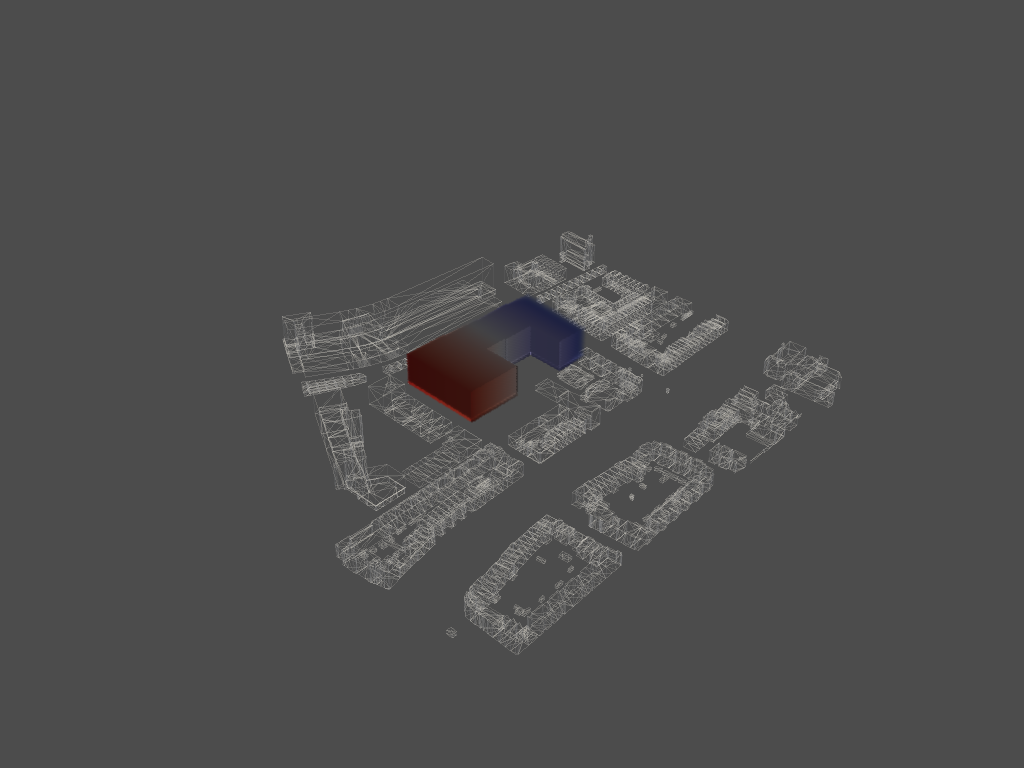

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [12]:
# extracting the centroid of all voxels
env_cens = envelope_lattice.centroids_threshold(-1)

# initializing the distance matrix
dist_m = []
# for each voxel ...
for voxel_cen in env_cens:
    # initializing the distance vector (per each voxel)
    dist_v = []
    # for each street point ...
    for street_point in w_p:
        # find the difference vector
        diff = voxel_cen - street_point
        # raise the components to the power of two
        diff_p2 = diff**2
        # sum the components
        diff_p2s = diff_p2.sum()
        # compute the square root 
        dist = diff_p2s**0.5
        # add the distance to the distance vector
        dist_v.append(dist)
    # add the distance vector to the distance matrix
    dist_m.append(dist_v)
# change the distance matrix type, from list to array
dist_m = np.array(dist_m)

# find the distance to the closest street point for each voxel
min_dist = dist_m.min(axis=1)
# convert the minimum distance list to a lattice
street_eu_distance_lattice = tg.to_lattice(min_dist.reshape(envelope_lattice.shape), envelope_lattice)
# zero the value of the exterior voxels
w_d = street_eu_distance_lattice * envelope_lattice
w_d=(w_d-w_d.min())/(w_d.max()-w_d.min())

# initiating the plotter
p = pv.Plotter()
l=w_d
# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Distance"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# # fast visualization of the point cloud
# street_pc.fast_notebook_vis(p)

# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6]) * 1.5
p.add_volume(grid, cmap="coolwarm", opacity=opacity, shade=True, show_scalar_bar=False)

# plotting
p.show()


In [13]:
w_csv_path = os.path.relpath('../data/fields/west_o.csv')
w_d.to_csv(w_csv_path)

### North

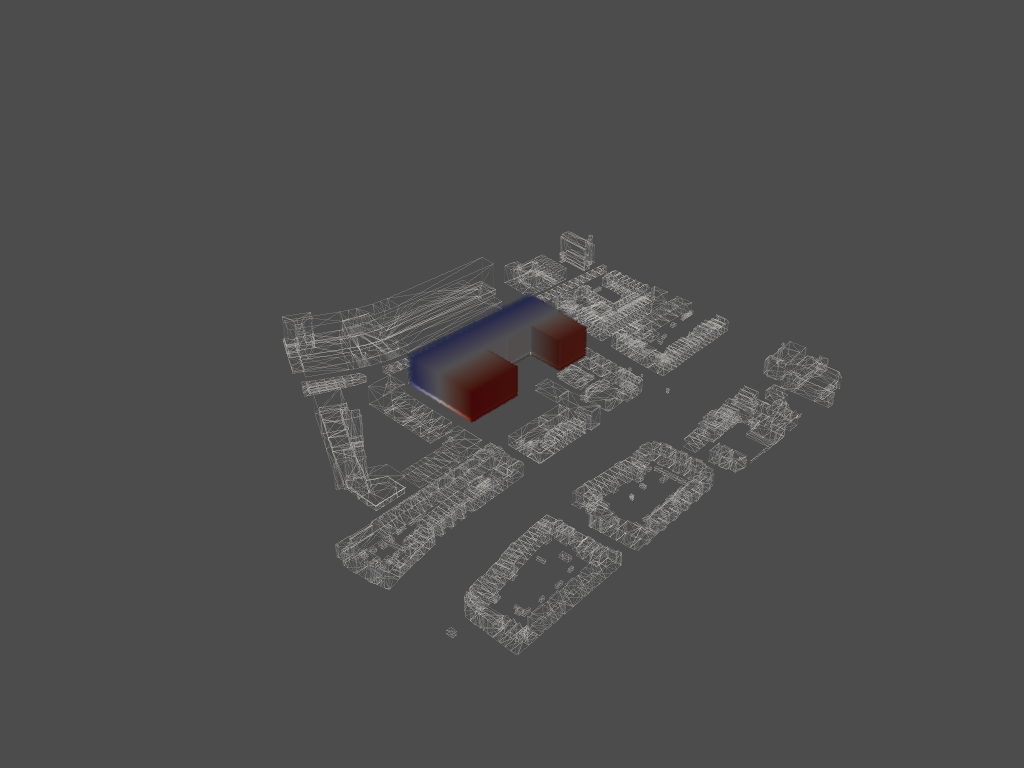

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [14]:
# extracting the centroid of all voxels
env_cens = envelope_lattice.centroids_threshold(-1)

# initializing the distance matrix
dist_m = []
# for each voxel ...
for voxel_cen in env_cens:
    # initializing the distance vector (per each voxel)
    dist_v = []
    # for each street point ...
    for street_point in s_p:
        # find the difference vector
        diff = voxel_cen - street_point
        # raise the components to the power of two
        diff_p2 = diff**2
        # sum the components
        diff_p2s = diff_p2.sum()
        # compute the square root 
        dist = diff_p2s**0.5
        # add the distance to the distance vector
        dist_v.append(dist)
    # add the distance vector to the distance matrix
    dist_m.append(dist_v)
# change the distance matrix type, from list to array
dist_m = np.array(dist_m)

# find the distance to the closest street point for each voxel
min_dist = dist_m.min(axis=1)
# convert the minimum distance list to a lattice
street_eu_distance_lattice = tg.to_lattice(min_dist.reshape(envelope_lattice.shape), envelope_lattice)
# zero the value of the exterior voxels
s_d = street_eu_distance_lattice * envelope_lattice
s_d=(s_d-s_d.min())/(s_d.max()-s_d.min())

# initiating the plotter
p = pv.Plotter()
l=s_d
# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Distance"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# # fast visualization of the point cloud
# street_pc.fast_notebook_vis(p)

# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6]) * 1.5
p.add_volume(grid, cmap="coolwarm", opacity=opacity, shade=True, show_scalar_bar=False)

# plotting
p.show()


In [15]:
s_csv_path = os.path.relpath('../data/fields/north_o.csv')
s_d.to_csv(s_csv_path)

## Credits

In [16]:
__author__ = "Shervin Azadi"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/earthy_workshops"
__summary__ = "Earthy Design Studio"